# Snapping Mechanism

### Problem Statement
The proofs of many differentially private algorithms rely on the ability to sample noise from $\mathbb{R}$. Modern computers support only approximations to $\mathbb{R}$, with the most common standard being the [IEEE 754](https://en.wikipedia.org/wiki/IEEE_754-1985) floating-point standard. The two most widely-used levels of precision used are "single" and "double", in which numbers are represented with 32 and 64 bits respectively. For the rest of this notebook, we will refer to the set of IEEE 754 double precision floating-point numbers as $\mathbb{F}$.

The extent to which $\mathbb{F}$ is a sufficient approximation to $\mathbb{R}$ depends heavily on the context -- let's start by considering the differences. $\mathbb{F}$ has finitely many elements while $\mathbb{R}$ has infinitely many elements, meaning that there are infinitely many elements of $\mathbb{R}$ that are not in $\mathbb{F}$. Moreover, $\mathbb{F}$ is not closed under many operations under which $\mathbb{R}$ is closed -- for example, $\forall r \in \mathbb{R}: e^r \in \mathbb{R}$ but $\exists f \in \mathbb{F}: e^f \not\in \mathbb{F}$. These properties mean that calculations on $\mathbb{F}$ introduce error that would not exist were the calculations done on $\mathbb{R}$. For fields where measurement is very precise, practitioners often need to be very careful about how they set up and perform calculations in order to minimize the effects of these errors.

[Mironov (2012)](https://www.microsoft.com/en-us/research/wp-content/uploads/2012/10/lsbs.pdf) showed that, in the case of the Laplace mechanism, $\mathbb{F} $ is not a sufficient approximation for $\mathbb{R}$. Differential privacy (DP) is all about bounding the difference in probabilities of all sets of events between neighboring data sets. The Laplace mechanism is supposed to respect $(\epsilon, 0)$-DP, meaning that these probabilities are uniformly bounded by a multiplicative term $e^{\epsilon}$ -- this implies that the mechanism must have the same support over neighboring data sets. Because of the errors in operations on $\mathbb{F}$, mechanisms with the same support when operating over $\mathbb{R}$ may not have the same support when operating over $\mathbb{F}$. To see a visual representation of this phenomenon with respect to the Laplace mechanism, see section 4.4 of Mironov (2012). 

This introduces a serious vulnerability for the Laplace mechanism. Figure 2 from Mironov (2012) shows how an attacker can effectively reconstruct private data from the output of the Laplace mechanism. 

### Snapping Mechanism Overview

Mironov (2012) proposes the Snapping mechanism as a replacement for the Laplace mechanism that is actually $(\epsilon, 0)$-DP when applied on $\mathbb{F}$. It looks a lot like the Laplace mechanism, but with a few major changes. First, Laplace noise is generated using a specific method for drawing from $\mathbb{F} \cap (0, 1)$ and a logarithm calculated with high precision. The noise is then added to the function value to be privatized, clamped to the interval $[-B, B]$ (for some specified $B$), snapped to a grid of points spaced $\Lambda$ apart ($\Lambda$ is calculated within the mechanism), and then clamped to $[-B, B]$ again. A more rigorous statement can be found in section 5.2 of Mironov (2012).

### Using the Snapping Mechanism

Below we show how to call the Snapping mechanism within the library and compare its performance to that of the Laplace mechanism. Note that when using the Snapping mechanism, the user has extra parameters *lower* and *upper* that represent the user's beliefs about a plausible range for the statistic in question (these are a generalization of the range $[-B, B]$ mentioned previously). If the user does not set *lower* and *upper*, they are set conservatively based on the provided bounds on the raw data and the statistic in question. 

In [1]:
# load libraries
import os
import numpy as np
import pandas as pd
import opendp.whitenoise.core as wn
import matplotlib.pyplot as plt 
import seaborn as sns

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married", "pid"]

# simulate laplace and snapping mechanism results
n_sims = 1_000
epsilons = [0.01, 0.1, 0.5, 1]
laplace_releases = []
snapping_releases = []

with wn.Analysis(dynamic = True) as analysis:
    data = wn.Dataset(path = data_path, column_names = var_names)
    age = wn.impute(
            wn.to_float(data['age']),
            data_lower = 0.,
            data_upper = 100.,
            data_rows = 1000)

    for epsilon in epsilons:
        for index in range(n_sims):
            # get DP mean of age
            laplace_releases.append(wn.dp_mean(data = age,
                                            mechanism = 'laplace',
                                            privacy_usage = {'epsilon': epsilon}))
            
            snapping_releases.append(wn.dp_mean(data = age,
                                            lower = 0.,
                                            upper = 100.,
                                            mechanism = 'snapping',
                                            privacy_usage = {'epsilon': epsilon}))


analysis.release()
laplace_values = [release.value for release in laplace_releases]
snapping_values = [release.value for release in snapping_releases]

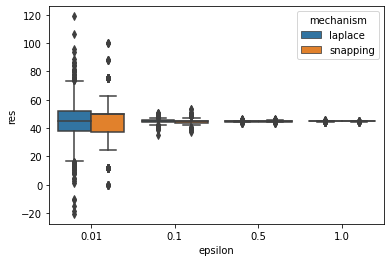

In [2]:
# plot results
epsilon_list = [[epsilon] * n_sims for epsilon in epsilons]
flatten = lambda l: [item for sublist in l for item in sublist]
df = pd.DataFrame({'mechanism': (['laplace'] * n_sims * len(epsilons)) + (['snapping'] * n_sims * len(epsilons)), 
                   'epsilon': flatten([flatten(epsilon_list)] * 2),
                   'res': list(laplace_values) + list(snapping_values)})
df['log_res'] = np.log(df['res'])

plot = sns.boxplot(x = 'epsilon', y = 'res', hue = 'mechanism', data = df)
plt.show()


The noise introduced by the Snapping mechanism typically looks more-or-less like that from the Laplace mechanism. One notable difference is that, due to the $\Lambda$-grid snapping, the Snapping mechanism does not, in general, draw from a symmetric noise distribution about the true statistic value as the Laplace does. This means that the Snapping mechanism is a biased estimator of the true value of the statistic. For a more complete treatment of the Snapping mechanism and its utility guarantees, see [here](https://github.com/ctcovington/floating_point).

### References

Mironov, Ilya. "On significance of the least significant bits for differential privacy." *Proceedings of the 2012 ACM conference on Computer and communications security.* 2012.